<a href="https://colab.research.google.com/github/Bryan-Az/Neurobytes/blob/notebooks/mlops/notebooks/users_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of the Synthetic User Preferences


## Spotify Million Song Dataset (Via Kaggle)
This synthetic dataset was generated with the Kaggle 'Spotify Million Song' dataset.

The original data contains the features:

- 'artist': The name of the artist
- 'song': The name of the song
- 'text': The song lyrics
- 'link': The link to the song via spotify api

A sample of 10,000 rows was selected from this dataset to calculate synthetic user preferences, as the original dataset is very large. The document-term matrix was calculated, where each song is a document and the words in the lyrics are the terms.

## Synthetic User Preference Data

The cosin similarity was calculated, representing the similarity between from songs-to-songs by their lyrics. This data was then used to calculate synthetic user data by sampling a 'starter' song for each user, and then using the top 3 similar songs to the original song as their sample user preferences. Then, the following two columns were added to a new user preferences dataset:

- 'songID': a many-to-one foreign key to the original song dataset.
- 'userID': a many-to-one userID index.

Our synthetic user prefernce generator selects n_starter songs and then uses cosin similarity to select n further top-n similar songs for the original n_starter song, such that each user will have a variety of 'tastees'.

 For example, each 'song cluster' sample (n_starter) includes self (original song) with similarity of 1, then included n similar songs (starter song + n similar songs).
  
  To calculate the size, for example, n = 3, songs_per_user = 50, num_users=1000
  returns: num_users * (n + 1) * (songs_per_user) = ~200,000 preferences (variable as n_starter is random value between 40-50).



In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
users_glink = 'https://drive.google.com/file/d/1fw3kszKGlaz4x6oMgCMNmY_s3ejwdGxT/view?usp=drive_link'
filename = 'user_preferences.csv'

In [5]:
def get_link_content(link, name):
  file_id = link.split('/')[-2]
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(name)

In [6]:
get_link_content(users_glink, filename)

In [7]:
user_preferences = pd.read_csv(filename, index_col=0).sort_values(by='userID').loc[:, ['userID','songID', 'artist', 'song', 'text', 'link']]

In [19]:
user_preferences.shape

(178340, 6)

# Identifying the 'Favorite'/'Most Listened' to Artist's

As the algorithm to generate synthetic user preferences assigned users clusters of songs that had fairly similar cosin similarity (at random, based on samples of the main dataset) using the lyric information, every user should have a different set of artists and a different ranking of artists by # songs within the user preferences dataset.

In [46]:
preference_size_distribution = user_preferences.groupby('userID').count().describe()['songID'] # the general distribution of # of songs per user, for 1000 users
preference_size_distribution

count    1000.000000
mean      178.340000
std        11.171804
min       160.000000
25%       168.000000
50%       180.000000
75%       188.000000
max       196.000000
Name: songID, dtype: float64

In [48]:
sample_user = user_preferences.where(user_preferences['userID'] == user_preferences['userID'].sample(1).iloc[0]).dropna() # a sample user

In [49]:
sample_user.groupby('artist').count().mean(axis=1).sort_values(ascending=False).head(10) # top 10 artists

artist
Z-Ro               6.0
Queen Latifah      5.0
Marillion          4.0
Xzibit             3.0
Hank Snow          3.0
Rush               3.0
Jennifer Lopez     3.0
Robbie Williams    3.0
Keith Green        3.0
Kanye West         3.0
dtype: float64

Given a sample user, it seems that identifying their 'favorite' artist would be a tough choice to make. The majority of artists within this sample user's preferences only make one or two appearances, and any artist with more than 3 appearances is very rare.

My theory is that given that 'artist' name was not used as input to the cosin similarity algorithm, it could be ignoring the artist's identities when making recommendations, and user preferences do not seem to skew to any particular artist.

<Axes: >

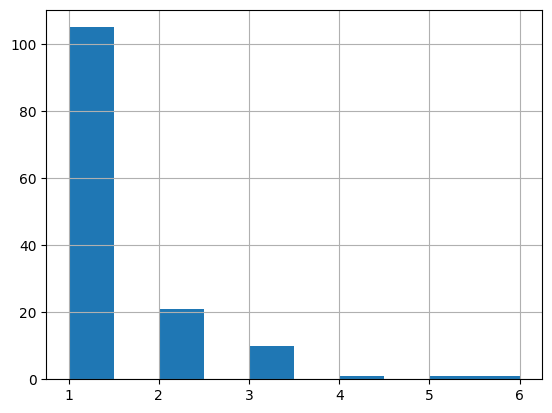

In [51]:
# plotting the distribution of artist count for the sample user
sample_user.groupby('artist').count().mean(axis=1).hist(bins=10)

By visualizing the same distribution - this time using the entire user preferences dataset - we can see that most artists make an appearance within a user's library 1-3 times, with a small right tail skewing the distribution towards 4-8 appearances.

Perhaps including the artist's name or the album name into the document-term matrix before generating the synthetic user preferences would allow for a more concentrated selection of choices that might mimic how individual user's tend to favor entire albums or playlists centered around a particular artist.

<Axes: >

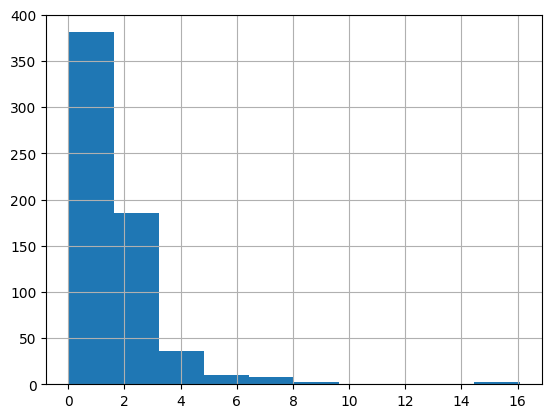

In [52]:
# plotting similar distribution using the entire dataset
(user_preferences.groupby('artist').count() / preference_size_distribution['mean']).mean(axis=1).hist(bins=10)